# Trainig a Model Using the MNIST datase for recgonise hand-writen digits
   
On this notebook we show how to create a model and train using  MNIST dataset for recognise handwritten digits.
We start showing how to read the bits from the dataset, then we do a quick introduction to neural network what 
is useful for understand the model thath we will train.
We start with a simple linear model, for then add convolutional and maxpooling layers.
At the end we use data augmentation and train for several epoch our model to try to get a high hit on the test data set.



# The Data

  We will start by understanding how the data is formatted and see hot we can parse it in a  suitable way for train our model.
  
  Mnist provide 4 files:
  
  -   training set images 
  -   training set labels
  -   test set images
  -   test set labels 
 
   [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/) 



## Little and Big Endian Architecture 

  There are 2 types of processors architecture(little and big endian). In little endian bits are store from left to right This is basically how the bytes are stored, in little they are stored from left to right and in big the other way around.(Look this is you want to know more about https://chortle.ccsu.edu/AssemblyTutorial/Chapter-15/ass15_3.html ).
  This is relevant for us because we need to know read the bytes right for get the proper data.
  
  In python we can easily check using sys, since I am using a Intel processor I expected to be little.


In [1]:
import numpy as np
from sys import byteorder

Now we can check  our architecture:

In [2]:
print(byteorder)

little


## Reading Mnist

  Now we can start reading the train images file. 
  From Mnist website we know what to expected from each bit read.


In [3]:
import gzip

with gzip.open('mnist/train-images-idx3-ubyte.gz', 'rb') as f:
    fc_train_img = f.read()

  The first 4 bytes is the magic number which is a 32 bit integer, for the image set this number is 2051. Note that we are setting the byte order as big.

In [4]:
int.from_bytes(fc_train_img[0:4], byteorder='big')

2051

Next is the number of images as a 32 bit integer:

In [5]:
train_img_total = int.from_bytes(fc_train_img[4:8], byteorder='big')
train_img_total

60000

Then number of rows as 32 bit integer.

In [6]:
row = int.from_bytes(fc_train_img[8:12], byteorder='big')
row

28

And  columns  32 bit integer as well.

In [7]:
col = int.from_bytes(fc_train_img[12:16], byteorder='big')
col

28

Then all next are  unsigned bytes(8 bits) , each byte represent a pixel. They are organized row-wise.

The total of bits is: 
```python
train_img_total*row*col
```





In [8]:
last_byte = (train_img_total*row*col) + 16
last_byte

47040016

Now whe can read all bits:

In [9]:
x_train = list(fc_train_img[16:last_byte])

And reshape them ass 28*27 (784) array. That is the vector representation of the images.

In Mnist pixel values are 0 to 255.0 , 0 representing the background. We want to invert this, because having a non zero value as background is better for the training.

In [10]:
x_train = ~np.array(x_train).reshape(train_img_total,row*col).astype(np.uint8)
x_train.shape

(60000, 784)

We can see one image using pyplot:

In [11]:
import matplotlib.pyplot as plt
plt.imshow(x_train[11].reshape(row,col), cmap='gray')

Thats look like the image 11 is a 5. We can now read labels and check.

In [12]:
with gzip.open('mnist/train-labels-idx1-ubyte.gz', 'rb') as f:
    fc_train_lbl = f.read()

First 32 bits are the magic number : 2049

In [13]:
int.from_bytes(fc_train_lbl[0:4], byteorder='big')


2049

Then a 32 bits integer, the total of labels. Must be 6000 as we got 6000 images.

In [14]:
train_lvl_total = int.from_bytes(fc_train_lbl[4:8], byteorder='big')
train_lvl_total

60000

Now each unsigned byte is a label, so we can check that 11 is 5:

In [15]:
y_train = np.array(list(fc_train_lbl[8:train_lvl_total+8]))
print(y_train[11])

5


We now real the test images and labels:

In [16]:
with gzip.open('mnist/t10k-images-idx3-ubyte.gz', 'rb') as f:
    fc_test_img = f.read()
with gzip.open('mnist/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    fc_test_lbl = f.read()
    
test_img_total = int.from_bytes(fc_test_img[4:8], byteorder='big')
test_lbl_total = int.from_bytes(fc_test_lbl[4:8], byteorder='big')

last_byte = (test_img_total*row*col) + 16
x_test = list(fc_test_img[16:last_byte])
x_test = ~np.array(x_test).reshape(test_img_total,row*col).astype(np.uint8)

y_test = np.array(list(fc_test_lbl[8:test_lbl_total+8]))

In [17]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [18]:
x_train =  x_train/255.0
x_test = x_test/255.0

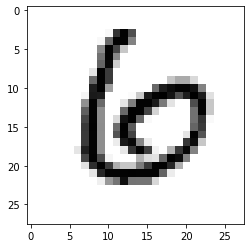

In [19]:
plt.imshow(x_test[11].reshape(row,col), cmap='gray')

In [20]:
print(y_test[11])

6


# Neuron Network

Most people can recognize handwrite digits with no problem(because we have a very complex brain). This is not a easy task for a computer. We will use the neural network approach, we will take a large number of labelled handwrite digits -the training examples- (x_train), and create a model that can learn from those examples.


## Neurons

The idea is simple, they take several inputs(  $ x_1, x_2 ... x_n $) and produce a single output.




![Single neuron](img/SingleNeuron.png)

Each input have  <i>weights</i>  $ w_1, w_2 ... w_n $ , a weight sum is calculated:${\sum_n x_n w_n}$ then the results goes through a activation function.

[http://neuralnetworksanddeeplearning.com/chap1.html](http://neuralnetworksanddeeplearning.com/chap1.html/) 

[https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/keras-neurons.ipynb](https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/keras-neurons.ipynb) 



## Layers

We create layers composed of neurons. at least one input layer and a output layer is required, there can be hidden layers between the input and output layer. 

Our images are 28x28, we can create a 784 vector that represent the image. So we will feed out network with 784 inputs, this is our input layer that is also know as hidden layer.
Since we need to discriminate 10 numbers out output layer will have 10 neurons, each will represent a digit from 0 to 9. Then we can use SoftMax activation function for the output of each of our network to represent a probability of being a digit.


## Activation : softmax
   We want our result to represent a probability of being one of the 10 digits(0,1,3...).
  The SoftMax activation function will do this for us, it will output our output for each neuron between 0 and 1.Then each 
  of our neuron can represent a digit so the one will bigger probability will be our prediction.

  
  $$\sigma (z)_j = \frac{e^{(z)_j}}{\sum_{k=0}^{K}e^{(z)_k}} \text{  where   j = 1,...,K}$$  
  
  In our case K = 10.
  
  https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/

## First model

 We will start create a 2 layers model, input and output : the input layer will be the 784 vector created with the image data and the output a 10 neuros with activation SoftMax. 
 

![Single neuron](img/Model1.png)

We will use keras and TensorFlow

In [21]:
import keras as kr

Using TensorFlow backend.


In [22]:
# create sequeantial model
model = kr.models.Sequential()

# The input layer is added by keras when we set input = 784 
# We add 10 neuroas with softmax for output
model.add(kr.layers.Dense(units=10, input_dim=784, activation='softmax'))

# Compile the model.
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

We can se a summary of our model:

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


The 7850 parameters are:
 10 weights from each input node to each output made 7840 plus 10 weights on the outputs nodes.


We are missing few thinks to explain: loss, optimizer and metrics.

## Loss : categorical_crossentropy


 This is how we measure how well our algorithm model the dataset. 
   
 Categorical cross entropy is used when only one value can belong to each class (our 10 outputs), so just what we need for measure our model because we are looking for predicted one number. Our output should be the number prediction.

   
   [https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy)
   
   
  [https://algorithmia.com/blog/introduction-to-loss-functions](https://algorithmia.com/blog/introduction-to-loss-functions)
    

## Optimazer : adam

When we are training our model the weights are change acordally for make our prediction better. How much and how are they change is the job of the optimizer, is the optimizer who shape our model for a correct prediction.

Adaptative moment estimation(ADAM) use gradient decent. This is how it work([literally taked from Algorithmia](https://algorithmia.com/blog/introduction-to-optimizers)  )


1) Calculate what a small change in each individual weight would do to the loss function (i.e. which direction should the hiker walk in)

2) Adjust each individual weight based on its gradient (i.e. take a small step in the determined direction)

3) Keep doing steps #1 and #2 until the loss function gets as low as possible



Adam use pas gradients to calculate current gradients and also utilizes the concept of [momentun](https://ruder.io/optimizing-gradient-descent/index.html#momentum).


[https://keras.io/optimizers/](https://keras.io/optimizers/)


[https://www.kdnuggets.com/2017/04/simple-understand-gradient-descent-algorithm.html](https://www.kdnuggets.com/2017/04/simple-understand-gradient-descent-algorithm.html)


[https://https://algorithmia.com/blog/introduction-to-optimizers.com/blog/introduction-to-optimizers](https://https://algorithmia.com/blog/introduction-to-optimizers.com/blog/introduction-to-optimizers)

## Preparing the labes
    
We are almost done for train our model for first time, the only problems is that our labels are a single digit. We need make them vectors with a 1 on the number position.

In [25]:
y_train = kr.utils.to_categorical(y_train, 10)
y_test  = kr.utils.to_categorical(y_test, 10)

In [26]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

Now we are ready, we will start training this simple model with 10 epochs, batch of 100 (means we train the model with 100 images at a time).

In [30]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 20us/step - loss: 0.3037 - accuracy: 0.9138 - val_loss: 0.2951 - val_accuracy: 0.9153
Epoch 2/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.3045 - accuracy: 0.9125 - val_loss: 0.2970 - val_accuracy: 0.9155
Epoch 3/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.3004 - accuracy: 0.9140 - val_loss: 0.2994 - val_accuracy: 0.9145
Epoch 4/10
60000/60000 [==============================] - 1s 20us/step - loss: 0.2971 - accuracy: 0.9149 - val_loss: 0.3039 - val_accuracy: 0.9109
Epoch 5/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.2959 - accuracy: 0.9160 - val_loss: 0.2906 - val_accuracy: 0.9129
Epoch 6/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.2959 - accuracy: 0.9161 - val_loss: 0.2936 - val_accuracy: 0.9176
Epoch 7/10
60000/60000 [==============================] - 1s 19us/st

## First results

We have achieved a 99.67 accuracy with this very simple model, this is going to be our baseline and we change our model for improve the results.

We can get data history, since we will be doing this several times I also define a function for use later.

In [31]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])

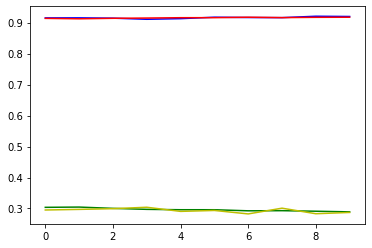

In [33]:
x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,'b',x,accuracy,'r',x,loss,'g',x,val_loss,'y')

- Red : Test accuracy.
- Blue : Train accuracy.
- Green : Train loss.
- Yellow: Test loss.

# Adding more Layers and Relu activation function

# Relu

Rectified linear unit(Relu), is one of the most common activation functions in neural networks. Relu is very simple, linear for all positive values and 0 for all negative values:
$$ f(x)       \begin{cases}
       \text{0,} &\quad\text{if } x \le0\\
       f(x) &\quad\text{if } x  >0 \\
       \end{cases}$$


![Relu](img/relu.png)

# Some advantages of Relu:
- Cheap to compute.
- Good sparsity.
- Converge faster.

[https://keras.io/activations/](https://keras.io/activations/)

[https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7](https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7) 

[https://datascience.stackexchange.com/questions/14349/difference-of-activation-functions-in-neural-networks-in-general](https://datascience.stackexchange.com/questions/14349/difference-of-activation-functions-in-neural-networks-in-general)

## Extra layers

We can now add more layers using Relu activation function:
- Same input layer.
- Hidden layers  512 and 98 neurons, with Relu.
- Same output layer, 10 neurons with SoftMax.

In [34]:
model = kr.models.Sequential()
model.add(kr.layers.Dense(units=512, input_dim=784, activation='relu'))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_3 (Dense)              (None, 98)                50274     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                990       
Total params: 453,184
Trainable params: 453,184
Non-trainable params: 0
_________________________________________________________________


In [36]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.5423 - accuracy: 0.8394 - val_loss: 0.3316 - val_accuracy: 0.9021
Epoch 2/10
60000/60000 [==============================] - 2s 27us/step - loss: 0.3153 - accuracy: 0.9043 - val_loss: 0.2875 - val_accuracy: 0.9147
Epoch 3/10
60000/60000 [==============================] - 2s 25us/step - loss: 0.2428 - accuracy: 0.9259 - val_loss: 0.2030 - val_accuracy: 0.9377
Epoch 4/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.1874 - accuracy: 0.9427 - val_loss: 0.1654 - val_accuracy: 0.9502
Epoch 5/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.1652 - accuracy: 0.9490 - val_loss: 0.1600 - val_accuracy: 0.9511
Epoch 6/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.1423 - accuracy: 0.9557 - val_loss: 0.1717 - val_accuracy: 0.9464
Epoch 7/10
60000/60000 [==============================] - 2s 26us/st

In [ ]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])

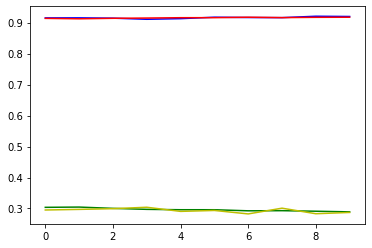

In [38]:
x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,'b',x,accuracy,'r',x,loss,'g',x,val_loss,'y')

Relu and the extra layers have give a great improvement to our model, from 91% to 96.5%.

# Dropout

Drop out is regularization technic, basically we drop some random neurons during training, 
they are temporary shutted down. 

Is believe that this make other neurons be more active so improve the learning rate.

The effect is a network that is less sensitive to specific weights of neurons. The network is capable of a better generalization and avoid overfit.

Drop out is very easily implemented with Keras, we just need to pick a percent of dropped out neurons for each epoch.


[https://keras.io/layers/core/](https://keras.io/layers/core/)

[https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)

In [39]:
model = kr.models.Sequential()
model.add(kr.layers.Dense(units=512, input_dim=784, activation='relu'))
model.add(kr.layers.Dropout(0.01))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 98)                50274     
_________________________________________________________________
dropout_2 (Dropout)          (None, 98)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                990       
Total params: 453,184
Trainable params: 453,184
Non-trainable params: 0
_________________________________________________________________


In [41]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.6083 - accuracy: 0.8098 - val_loss: 0.3417 - val_accuracy: 0.9050
Epoch 2/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.3152 - accuracy: 0.9043 - val_loss: 0.2256 - val_accuracy: 0.9320
Epoch 3/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.2407 - accuracy: 0.9266 - val_loss: 0.1873 - val_accuracy: 0.9446
Epoch 4/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.1991 - accuracy: 0.9383 - val_loss: 0.1517 - val_accuracy: 0.9516
Epoch 5/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.1721 - accuracy: 0.9467 - val_loss: 0.1546 - val_accuracy: 0.9503
Epoch 6/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.1562 - accuracy: 0.9513 - val_loss: 0.1414 - val_accuracy: 0.9537
Epoch 7/10
60000/60000 [==============================] - 2s 29us/st

In [ ]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])

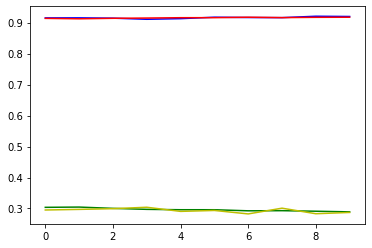

In [42]:

x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,'b',x,accuracy,'r',x,loss,'g',x,val_loss,'y')

Dropout improve our model from 96.5% to 97%, so now we are at 97%.

# 2D Convolutional Neural Network

We have achieve 97% accuracy on our model, but we are missing a very important point : shapes are 2D images and there is a relation between pixels. Transforming our image in a 1D vector we completely ignore the shape of the image.
Using convolutional neurons we can feed neurons with 2D arrays of pixels and someone preserve the data on the shape of the image.

In the image bellow we can see how a 3x3 convolutional networks works. Note that the image is just for illustrate how convolutional networks works, is not related with the one we will use.


![Conv2d](img/conv2d.gif)

### image from:  [https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)

[https://keras.io/layers/convolutional/](https://keras.io/layers/convolutional/)

[https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

## Reforating input data for convolutional network

We now need to reshape our data for be a 28 by 28 array so it can be fit onto the convolutional network.

In [27]:
x_train = x_train.reshape(train_img_total,col,row,1)
x_test = x_test.reshape(test_img_total,col,row,1)

In [28]:
x_train.shape

(60000, 28, 28, 1)

In [45]:
model = kr.models.Sequential()

model.add(kr.layers.Conv2D(256,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.Flatten())
model.add(kr.layers.Dropout(0.25))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [46]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 13s 220us/step - loss: 0.3485 - accuracy: 0.9028 - val_loss: 0.0834 - val_accuracy: 0.9744
Epoch 2/10
60000/60000 [==============================] - 12s 194us/step - loss: 0.0840 - accuracy: 0.9750 - val_loss: 0.0625 - val_accuracy: 0.9796
Epoch 3/10
60000/60000 [==============================] - 12s 193us/step - loss: 0.0576 - accuracy: 0.9813 - val_loss: 0.0562 - val_accuracy: 0.9815
Epoch 4/10
60000/60000 [==============================] - 12s 194us/step - loss: 0.0412 - accuracy: 0.9865 - val_loss: 0.0636 - val_accuracy: 0.9817
Epoch 5/10
60000/60000 [==============================] - 12s 194us/step - loss: 0.0297 - accuracy: 0.9901 - val_loss: 0.0548 - val_accuracy: 0.9825
Epoch 6/10
60000/60000 [==============================] - 12s 194us/step - loss: 0.0231 - accuracy: 0.9924 - val_loss: 0.0645 - val_accuracy: 0.9816
Epoch 7/10
60000/60000 [==============================] 

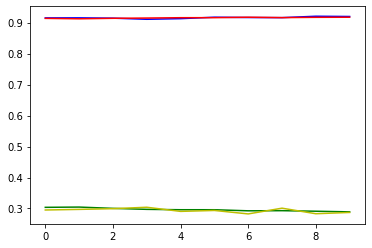

In [47]:
get_stats()
x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,'b',x,accuracy,'r',x,loss,'g',x,val_loss,'y')

With just 1 convolutional layer we have improve our accuracy to 98%

## More layers and max polling

A polling layer is a layer that we add after a convolutional layer.  The polling layer will operate over each pixel for create a new set of pulled data. We will use max polling of size 2x2 pixels. This means that the maximum of each 2x2 patch will be calculated.

### Benefits:

- Model invariance to local translation.
- Faster computations.



![MAxPolling2d](img/maxpolling2d.png)

image from: [https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/](https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/)

[https://keras.io/layers/pooling/](https://keras.io/layers/pooling/)

[https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/)

In [29]:
model = kr.models.Sequential()
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu',input_shape=(28,28,1)))
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Conv2D(128,kernel_size=(5, 5),activation='relu'))
model.add(kr.layers.Conv2D(256,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Flatten())
model.add(kr.layers.Dropout(0.25))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [49]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 92us/step - loss: 0.2337 - accuracy: 0.9265 - val_loss: 0.0642 - val_accuracy: 0.9805
Epoch 2/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.0605 - accuracy: 0.9825 - val_loss: 0.0342 - val_accuracy: 0.9896
Epoch 3/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0458 - accuracy: 0.9870 - val_loss: 0.0282 - val_accuracy: 0.9913
Epoch 4/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0368 - accuracy: 0.9894 - val_loss: 0.0287 - val_accuracy: 0.9916
Epoch 5/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0308 - accuracy: 0.9912 - val_loss: 0.0260 - val_accuracy: 0.9925
Epoch 6/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0264 - accuracy: 0.9924 - val_loss: 0.0280 - val_accuracy: 0.9913
Epoch 7/10
60000/60000 [==============================] - 5s 87us/st

## Batch normalization

In [53]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])


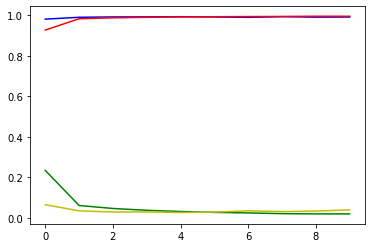

In [54]:
x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,'b',x,accuracy,'r',x,loss,'g',x,val_loss,'y')

## Batch Normalization


In [55]:
model = kr.models.Sequential()
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu',input_shape=(28,28,1)))
kr.layers.BatchNormalization(axis=-1)
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu'))
kr.layers.BatchNormalization(axis=-1)
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Conv2D(128,kernel_size=(5, 5),activation='relu'))
kr.layers.BatchNormalization(axis=-1)
model.add(kr.layers.Conv2D(256,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Flatten())
model.add(kr.layers.Dropout(0.25))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [56]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 89us/step - loss: 0.2251 - accuracy: 0.9283 - val_loss: 0.0612 - val_accuracy: 0.9821
Epoch 2/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.0595 - accuracy: 0.9826 - val_loss: 0.0380 - val_accuracy: 0.9891
Epoch 3/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.0444 - accuracy: 0.9873 - val_loss: 0.0290 - val_accuracy: 0.9912
Epoch 4/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0357 - accuracy: 0.9896 - val_loss: 0.0353 - val_accuracy: 0.9902
Epoch 5/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.0306 - accuracy: 0.9912 - val_loss: 0.0315 - val_accuracy: 0.9895
Epoch 6/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.0242 - accuracy: 0.9927 - val_loss: 0.0311 - val_accuracy: 0.9910
Epoch 7/10
60000/60000 [==============================] - 5s 86us/st

In [57]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])

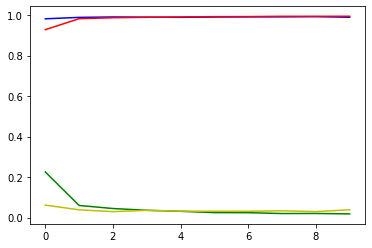

In [58]:
x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,'b',x,accuracy,'r',x,loss,'g',x,val_loss,'y')

In [48]:
cbk = CustomModelCheckpoint()

# Final Model

![Final Model](img/finalmodel.png)

* image created using : [NN-SVG](http://alexlenail.me/NN-SVG/LeNet.html)


In [30]:
model = kr.models.Sequential()
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu',input_shape=(28,28,1)))
kr.layers.normalization.BatchNormalization(axis=-1)
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu',input_shape=(28,28,1)))
kr.layers.normalization.BatchNormalization(axis=-1)
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Conv2D(128,kernel_size=(5, 5),activation='relu'))
model.add(kr.layers.Conv2D(256,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Dropout(0.25))
model.add(kr.layers.Flatten())
#model.add(kr.layers.Dense(units=128, activation='relu'))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss=kr.losses.categorical_crossentropy,optimizer='adadelta',metrics=['accuracy'])
model.summary()
 



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 22, 22, 64)        3200      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        200768    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 128)         204928    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 256)         295168    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 1, 256)        

# Data Augmentation Image Generator

https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced


In [31]:
from keras.preprocessing.image import ImageDataGenerator

In [32]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
test_gen = ImageDataGenerator()

In [33]:
train_generator = gen.flow(x_train, y_train, batch_size=64)
test_generator = test_gen.flow(x_test, y_test, batch_size=64)

In [34]:
epoch =10
history_callback= model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=epoch, 
                    validation_data=test_generator, validation_steps=10000//64)

Epoch 1/10
937/937 [==============================] - 12s 12ms/step - loss: 0.2851 - accuracy: 0.9073 - val_loss: 0.0039 - val_accuracy: 0.9880
Epoch 2/10
937/937 [==============================] - 10s 11ms/step - loss: 0.0711 - accuracy: 0.9786 - val_loss: 0.0776 - val_accuracy: 0.9915
Epoch 3/10
937/937 [==============================] - 9s 10ms/step - loss: 0.0543 - accuracy: 0.9845 - val_loss: 0.0011 - val_accuracy: 0.9941
Epoch 4/10
937/937 [==============================] - 9s 10ms/step - loss: 0.0459 - accuracy: 0.9866 - val_loss: 7.4667e-05 - val_accuracy: 0.9916
Epoch 5/10
937/937 [==============================] - 10s 11ms/step - loss: 0.0404 - accuracy: 0.9888 - val_loss: 6.6827e-05 - val_accuracy: 0.9938
Epoch 6/10
937/937 [==============================] - 10s 10ms/step - loss: 0.0359 - accuracy: 0.9899 - val_loss: 0.0013 - val_accuracy: 0.9948
Epoch 7/10
937/937 [==============================] - 10s 10ms/step - loss: 0.0324 - accuracy: 0.9909 - val_loss: 0.0059 - val_acc

In [35]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])


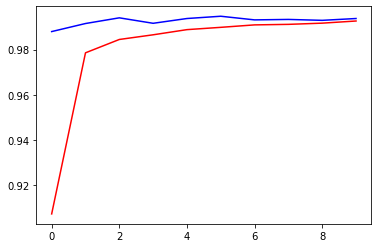

In [36]:
x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,'b',x,accuracy,'r')

# Looking for high hit

## Custom Checkpoint


In [37]:
class CustomModelCheckpoint(kr.callbacks.Callback):
    minimun = 0.99
   

    def on_epoch_end(self, epoch, logs=None):
        score = self.model.evaluate(x_test, y_test, verbose=0)
        # logs is a dictionary
        print(f"epoch: {epoch},history_callback.{logs['val_accuracy']}")
        print(score[1])
        if score[1] > self.minimun: # your custom condition
    
            self.model.save('model7.h5', overwrite=True)
           
            
            
           
            
            self.minimun = score[1]
            print(self.minimun)
            print("*****************************************************************************************************")

In [38]:
cbk = CustomModelCheckpoint()

In [56]:
epoch =100
history_callback= model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=epoch, 
                    validation_data=test_generator, validation_steps=10000//64, callbacks=[cbk])

Epoch 1/100
937/937 [==============================] - 10s 10ms/step - loss: 0.0091 - accuracy: 0.9990 - val_loss: 0.0000e+00 - val_accuracy: 0.9954
epoch: 0,history_callback.0.9953926205635071
0.9954000115394592
Epoch 2/100
937/937 [==============================] - 10s 11ms/step - loss: 0.0110 - accuracy: 0.9988 - val_loss: 0.0000e+00 - val_accuracy: 0.9950
epoch: 1,history_callback.0.9949678182601929
0.9950000047683716
Epoch 3/100
937/937 [==============================] - 10s 10ms/step - loss: 0.0128 - accuracy: 0.9987 - val_loss: 0.0000e+00 - val_accuracy: 0.9951
epoch: 2,history_callback.0.9950684309005737
0.9951000213623047
Epoch 4/100
937/937 [==============================] - 10s 10ms/step - loss: 0.0134 - accuracy: 0.9985 - val_loss: 0.1702 - val_accuracy: 0.9957
epoch: 3,history_callback.0.9956722855567932
0.9957000017166138
Epoch 5/100
937/937 [==============================] - 10s 11ms/step - loss: 0.0123 - accuracy: 0.9989 - val_loss: 0.0000e+00 - val_accuracy: 0.9950
epo

937/937 [==============================] - 10s 10ms/step - loss: 0.0114 - accuracy: 0.9986 - val_loss: 2.8126e-07 - val_accuracy: 0.9959
epoch: 38,history_callback.0.9958735704421997
0.9955999851226807
Epoch 40/100
937/937 [==============================] - 10s 10ms/step - loss: 0.0130 - accuracy: 0.9986 - val_loss: 0.0000e+00 - val_accuracy: 0.9950
epoch: 39,history_callback.0.9949678182601929
0.9955000281333923
Epoch 41/100
937/937 [==============================] - 10s 11ms/step - loss: 0.0105 - accuracy: 0.9988 - val_loss: 0.0000e+00 - val_accuracy: 0.9953
epoch: 40,history_callback.0.9952697157859802
0.9951000213623047
Epoch 42/100
937/937 [==============================] - 9s 10ms/step - loss: 0.0088 - accuracy: 0.9990 - val_loss: 0.5448 - val_accuracy: 0.9954
epoch: 41,history_callback.0.9953703880310059
0.995199978351593
Epoch 43/100
937/937 [==============================] - 10s 10ms/step - loss: 0.0133 - accuracy: 0.9986 - val_loss: 2.0489e-08 - val_accuracy: 0.9942
epoch: 42

937/937 [==============================] - 10s 11ms/step - loss: 0.0131 - accuracy: 0.9988 - val_loss: 0.7280 - val_accuracy: 0.9948
epoch: 76,history_callback.0.9947665333747864
0.9943000078201294
Epoch 78/100
937/937 [==============================] - 10s 10ms/step - loss: 0.0125 - accuracy: 0.9987 - val_loss: 3.7253e-09 - val_accuracy: 0.9936
epoch: 77,history_callback.0.9935587644577026
0.9944000244140625
Epoch 79/100
937/937 [==============================] - 9s 10ms/step - loss: 0.0107 - accuracy: 0.9988 - val_loss: 0.0000e+00 - val_accuracy: 0.9956
epoch: 78,history_callback.0.9955716729164124
0.995199978351593
Epoch 80/100
937/937 [==============================] - 10s 11ms/step - loss: 0.0120 - accuracy: 0.9987 - val_loss: 0.0000e+00 - val_accuracy: 0.9956
epoch: 79,history_callback.0.9955716729164124
0.9952999949455261
Epoch 81/100
937/937 [==============================] - 10s 10ms/step - loss: 0.0138 - accuracy: 0.9986 - val_loss: 0.0000e+00 - val_accuracy: 0.9950
epoch: 80

In [46]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])


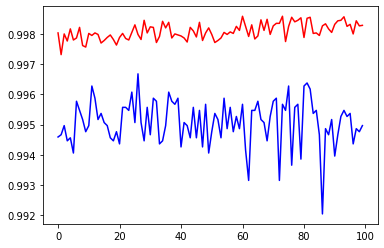

In [55]:
x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,'b',x,accuracy,'r')#,x,loss,'g',x,val_loss,'y')

In [86]:
loss[92]

0.0099964409139225

In [57]:
score = kr.models.load_model('./model7.h5').evaluate(x_test, y_test, verbose=0)
score

[0.046948431885341146, 0.9968000054359436]

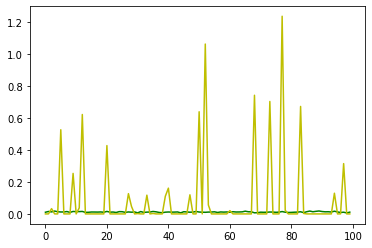

In [141]:
x = np.arange(0.0, epoch, 1)
plt.plot(x,loss,'g',x,val_loss,'y')